# Matrix vector multiplication in SHEEP
Since we can use "slots", i.e. vectors of input values, and many libraries support SIMD operations (i.e. operating on many slots is just as quick as operating on single values), we can easily do component-wise multiplication.  However, as with vector dot products, we generally need to also sum over slots, which can be done using a sequence of "ROTATE" and "ADD" operations.

In [2]:
import os
import sys
if "SHEEP_HOME" in os.environ.keys():
  SHEEP_HOME = os.environ["SHEEP_HOME"]
  sys.path.append(SHEEP_HOME)
else:
  print("Please set SHEEP_HOME environment variable to point to location of SHEEP/frontend")

## tabulating and plotting benchmark results
import pandas as pd
import matplotlib.pyplot as plt
from pysheep.database import session, BenchmarkMeasurement, Timing

from pysheep import sheep_client, benchmark_utils

## Multiplying a 4x4 matrix with a 4-component vector


Lets do the following calculation:
\begin{equation*}
\begin{vmatrix}
1, 2 , 3 , 4\\
5 , 6 , 7 , 8\\
9, 10, 11, 12 \\
13, 14 , 15, 16
\end{vmatrix}
\begin{vmatrix}
1 \\
2 \\
3 \\
4
\end{vmatrix}
\end{equation*}

which should give us the answer {30, 55, 110, 150}


### a) The straightforward (but non-optimal) way

Essentially the each element of the output vector will be the dot product of the corresponding row of the matrix with the vector.  We can therefore do this in the same way as was demonstrated in the vector_dot_product notebook, i.e. component-wise multiplication followed by a sequence of rotations and additions.

The circuit will look like:

In [9]:
circuit = """
INPUTS mrow_0 mrow_1 mrow_2 mrow_3 vec mask
CONST_INPUTS rotate_by_minus1 rotate_by_plus1 rotate_by_plus2 rotate_by_plus3
OUTPUTS output_vec 
# dot product of the first row with the vector
mrow_0 vec MULTIPLY prod_00
prod_00 rotate_by_minus1 ROTATE prod_01
prod_00 prod_01 ADD sum_00
prod_01 rotate_by_minus1 ROTATE prod_02
sum_00 prod_02 ADD sum_01
prod_02 rotate_by_minus1 ROTATE prod_03
sum_01 prod_03 ADD sum_0
# dot product of the second row with the vector
mrow_1 vec MULTIPLY prod_10
prod_10 rotate_by_minus1 ROTATE prod_11
prod_10 prod_11 ADD sum_10
prod_11 rotate_by_minus1 ROTATE prod_12
sum_10 prod_12 ADD sum_11
prod_12 rotate_by_minus1 ROTATE prod_13
sum_11 prod_13 ADD sum_1
# dot product of the third row with the vector
mrow_2 vec MULTIPLY prod_20
prod_20 rotate_by_minus1 ROTATE prod_21
prod_20 prod_21 ADD sum_20
prod_21 rotate_by_minus1 ROTATE prod_22
sum_20 prod_22 ADD sum_21
prod_22 rotate_by_minus1 ROTATE prod_23
sum_21 prod_23 ADD sum_2
# dot product of the third row with the vector
mrow_3 vec MULTIPLY prod_30
prod_30 rotate_by_minus1 ROTATE prod_31
prod_30 prod_31 ADD sum_30
prod_31 rotate_by_minus1 ROTATE prod_32
sum_30 prod_32 ADD sum_31
prod_32 rotate_by_minus1 ROTATE prod_33
sum_31 prod_33 ADD sum_3
# now we have four vectors, sum_0, sum_1, sum_2 and sum_3, where the first element is 
# the dot product of that row.  We need to isolate just this element, using mask, which is [1,0,0,0]
sum_0 mask MULTIPLY msum_0
sum_1 mask MULTIPLY msum_10
msum_10 rotate_by_plus1 ROTATE msum_1
sum_2 mask MULTIPLY msum_20
msum_20 rotate_by_plus2 ROTATE msum_2
sum_3 mask MULTIPLY msum_30
msum_30 rotate_by_plus3 ROTATE msum_3
# now we should have four vectors with one non-zero element each in the right place - need to sum them
msum_0 msum_1 ADD out_01
out_01 msum_2 ADD out_02
out_02 msum_3 ADD output_vec
"""

In [10]:
sheep_client.new_job()
sheep_client.set_context("SEAL")
sheep_client.set_input_type("int16_t")
sheep_client.set_circuit_text(circuit)
sheep_client.get_inputs()

{'content': ['mrow_0', 'mrow_1', 'mrow_2', 'mrow_3', 'vec', 'mask'],
 'status_code': 200}

In [11]:
sheep_client.get_const_inputs()

{'content': ['rotate_by_minus1',
  'rotate_by_plus1',
  'rotate_by_plus2',
  'rotate_by_plus3'],
 'status_code': 200}

In [12]:
sheep_client.set_inputs({"mrow_0": [1,2,3,4], "mrow_1": [5,6,7,8], "mrow_2": [9,10,11,12], "mrow_3": [13,14,15,16],"vec": [1,2,3,4], "mask": [1,0,0,0]})


{'content': '', 'status_code': 200}

In [13]:
sheep_client.set_const_inputs({"rotate_by_minus1": -1, "rotate_by_plus1": 1, "rotate_by_plus2": 2, "rotate_by_plus3":3})

{'content': '', 'status_code': 200}

In [14]:
sheep_client.run_job()

{'content': '', 'status_code': 200}

In [15]:
sheep_client.get_results()

{'content': {'cleartext check': {'is_correct': True},
  'outputs': {'output_vec': ['30,70,110,150']},
  'timings': {'decryption': '526.500000',
   'encryption': '5626.500000',
   'evaluation': '60207.900000',
   'msum_0': '118.800000',
   'msum_1': '152.000000',
   'msum_10': '117.000000',
   'msum_2': '133.500000',
   'msum_20': '118.500000',
   'msum_3': '123.900000',
   'msum_30': '167.800000',
   'out_01': '117.000000',
   'out_02': '167.600000',
   'output_vec': '117.200000',
   'prod_00': '5514.700000',
   'prod_01': '1562.500000',
   'prod_02': '891.100000',
   'prod_03': '799.100000',
   'prod_10': '166.900000',
   'prod_11': '84.100000',
   'prod_12': '6047.100000',
   'prod_13': '795.300000',
   'prod_20': '5169.800000',
   'prod_21': '795.500000',
   'prod_22': '787.800000',
   'prod_23': '845.600000',
   'prod_30': '807.200000',
   'prod_31': '5469.100000',
   'prod_32': '792.500000',
   'prod_33': '140.600000',
   'sum_0': '5310.600000',
   'sum_00': '5337.800000',
   'sum

So we do get the right answer - 'output_vec' is [30,70,110,150].

Lets upload this benchmark to the database, then do the same thing in HElib_Fp.

In [16]:
benchmark_utils.upload_results("matrix_vector_mult_4x4x4")

True

In [17]:
sheep_client.new_job()
sheep_client.set_context("HElib_Fp")
sheep_client.set_input_type("int16_t")
sheep_client.set_parameters({"Levels":30})
sheep_client.set_circuit_text(circuit)
sheep_client.set_inputs({"mrow_0": [1,2,3,4], "mrow_1": [5,6,7,8], "mrow_2": [9,10,11,12], "mrow_3": [13,14,15,16],"vec": [1,2,3,4], "mask": [1,0,0,0]})
sheep_client.set_const_inputs({"rotate_by_minus1": -1, "rotate_by_plus1": 1, "rotate_by_plus2": 2, "rotate_by_plus3":3})
sheep_client.run_job()

{'content': '', 'status_code': 200}

In [18]:
sheep_client.get_results()

{'content': {'cleartext check': {'is_correct': True},
  'outputs': {'output_vec': ['30,70,110,150']},
  'timings': {'decryption': '1378.400000',
   'encryption': '17499.300000',
   'evaluation': '253346.700000',
   'msum_0': '198.900000',
   'msum_1': '186.500000',
   'msum_10': '261.200000',
   'msum_2': '200.200000',
   'msum_20': '200.700000',
   'msum_3': '198.600000',
   'msum_30': '188.500000',
   'out_01': '202.400000',
   'out_02': '188.800000',
   'output_vec': '201.300000',
   'prod_00': '5237.300000',
   'prod_01': '17089.100000',
   'prod_02': '11809.200000',
   'prod_03': '17105.900000',
   'prod_10': '207.200000',
   'prod_11': '302.300000',
   'prod_12': '3467.700000',
   'prod_13': '18022.100000',
   'prod_20': '3355.700000',
   'prod_21': '15257.700000',
   'prod_22': '11929.600000',
   'prod_23': '15642.500000',
   'prod_30': '11993.400000',
   'prod_31': '3354.100000',
   'prod_32': '11972.300000',
   'prod_33': '201.200000',
   'sum_0': '5154.000000',
   'sum_00': '

HElib also got the correct answer.   Lets upload this to the database, then compare the timings with SEAL.

In [19]:
benchmark_utils.upload_results("matrix_vector_mult_4x4x4")

True

In [20]:
rows = session.query(BenchmarkMeasurement).filter_by(circuit_name="matrix_vector_mult_4x4x4").all()
df_dict = {"Context": [], "Gate": [], "Time": []}
for row in rows:
    timingdict = benchmark_utils.timing_per_gate_type(row.timings, circuit)
    for k,v in timingdict.items():
        df_dict["Context"].append(row.context)
        df_dict["Gate"].append(k)
        df_dict["Time"].append(v)
df = pd.DataFrame(df_dict)
df

,Context,Gate,Time
0,SEAL,ROTATE,19419.7
1,SEAL,MULTIPLY,12180.7
2,SEAL,ADD,26724.6
3,HElib_Fp,ROTATE,126739.0
4,HElib_Fp,MULTIPLY,21642.9
5,HElib_Fp,ADD,98588.9


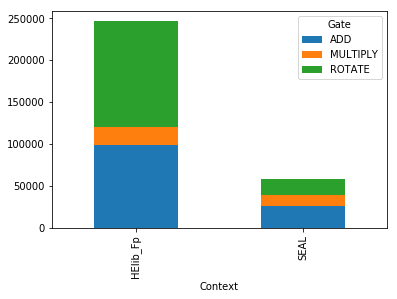

In [21]:
pivot_df = df.pivot(index='Context', columns='Gate', values='Time')
pivot_df.plot(kind='bar',stacked=True)

### b) A better way -  doing the same calculation with fewer ROTATEs.

The paper describing the [GAZELLE](https://eprint.iacr.org/2018/073.pdf) framework includes a clever method for speeding up matrix-vector multiplication with SIMD operations.
To minimize the number of intra-slot operations, we can express the matrix inputs as diagonal strips of the matrix.

In this case, the circuit will look like:

In [22]:
new_circuit = """
INPUTS mstrip_0 mstrip_1 mstrip_2 mstrip_3 vec 
CONST_INPUTS rotate_minus1
OUTPUTS output_vec 
mstrip_0 vec MULTIPLY prod_0
vec rotate_minus1 ROTATE vec_r1
mstrip_1 vec_r1 MULTIPLY prod_1
vec_r1 rotate_minus1 ROTATE vec_r2
mstrip_2 vec_r2 MULTIPLY prod_2
vec_r2 rotate_minus1 ROTATE vec_r3
mstrip_3 vec_r3 MULTIPLY prod_3
prod_0 prod_1 ADD sum_0
sum_0 prod_2 ADD sum_1
sum_1 prod_3 ADD output_vec
"""

In [23]:
sheep_client.new_job()
sheep_client.set_context("SEAL")
sheep_client.set_input_type("int16_t")
sheep_client.set_circuit_text(new_circuit)


{'content': '', 'status_code': 200}

We can set some of the inputs similarly to above.

In [24]:
const_input_vals = {"rotate_minus1": -1}
input_vals = {"vec": [1,2,3,4]}

So now we have to set the remaining inputs to be diagonal strips of the matrix:

In [25]:
input_vals["mstrip_0"] = [1,6,11,16]
input_vals["mstrip_1"] = [2,7,12,13]
input_vals["mstrip_2"] = [3,8,9,14]
input_vals["mstrip_3"] = [4,5,10,15]
sheep_client.set_inputs(input_vals)
sheep_client.set_const_inputs(const_input_vals)

{'content': '', 'status_code': 200}

In [26]:
sheep_client.run_job()

{'content': '', 'status_code': 200}

In [27]:
sheep_client.get_results()

{'content': {'cleartext check': {'is_correct': True},
  'outputs': {'output_vec': ['30,70,110,150']},
  'timings': {'decryption': '529.700000',
   'encryption': '4667.500000',
   'evaluation': '25295.500000',
   'output_vec': '796.900000',
   'prod_0': '83.500000',
   'prod_1': '5360.400000',
   'prod_2': '5345.200000',
   'prod_3': '93.400000',
   'sum_0': '798.000000',
   'sum_1': '798.000000',
   'vec_r1': '6094.400000',
   'vec_r2': '5303.400000',
   'vec_r3': '119.700000'}},
 'status_code': 200}

So this also got the right answer - [30,70,110,150].  Lets compare with HElib again:

In [28]:
benchmark_utils.upload_results("matrix_vector_mult_4x4x4_fast")

True

In [29]:
sheep_client.new_job()
sheep_client.set_context("HElib_Fp")
sheep_client.set_input_type("int16_t")
sheep_client.set_parameters({"Levels":10})
sheep_client.set_circuit_text(new_circuit)
sheep_client.set_inputs(input_vals)
sheep_client.set_const_inputs(const_input_vals)
sheep_client.run_job()

{'content': '', 'status_code': 200}

In [30]:
benchmark_utils.upload_results("matrix_vector_mult_4x4x4_fast")

True

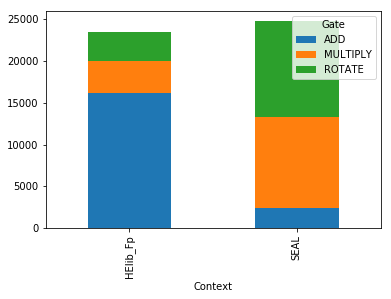

In [32]:
rows = session.query(BenchmarkMeasurement).filter_by(circuit_name="matrix_vector_mult_4x4x4_fast").all()
df_dict = {"Context": [], "Gate": [], "Time": []}
for row in rows:
    timingdict = benchmark_utils.timing_per_gate_type(row.timings, new_circuit)
    for k,v in timingdict.items():
        df_dict["Context"].append(row.context)
        df_dict["Gate"].append(k)
        df_dict["Time"].append(v)
df = pd.DataFrame(df_dict)
pivot_df = df.pivot(index='Context', columns='Gate', values='Time')
pivot_df.plot(kind='bar',stacked=True)

So we can see that although SEAL and HElib take very similar time overall to process this circuit, the time is spent in different operations.  
We can also see that both are a factor >10 faster than doing the computation the naive way.

### Generate circuits and inputs for matrix-vector multiplication

Note that there is a function in ```pysheep.mid_level_benchmarks``` called ```generate_matrix_vector_mult``` that will take a matrix (as a list of lists) and a vector (as a list), and return a circuit, dict-of-input-vals, and dict-of-output-vals, for use in this scheme.

Let's try it out:

In [33]:
sheep_client.new_job()

{'content': '', 'status_code': 200}

In [34]:
sheep_client.set_context("SEAL")

{'content': '', 'status_code': 200}

In [35]:
sheep_client.set_input_type("int16_t")

{'content': '', 'status_code': 200}

In [36]:
matrix = [[1,2,3],[5,6,7],[9,10,11]]
vec = [1,2,3]

In [37]:
from pysheep.mid_level_benchmarks import *
circ, inputs, const_inputs = generate_matrix_vector_mult(matrix,vec)

In [38]:
sheep_client.set_circuit_text(circ)
sheep_client.set_inputs(inputs)
sheep_client.set_const_inputs(const_inputs)

{'content': '', 'status_code': 200}

In [39]:
print(circ)

OUTPUTS output_vec
CONST_INPUTS rotate_minus1
INPUTS input_vec mstrip_0 mstrip_1 mstrip_2 
input_vec ALIAS vec_r0
mstrip_0 vec_r0 MULTIPLY prod_0
vec_r0 rotate_minus1 ROTATE vec_r1
mstrip_1 vec_r1  MULTIPLY prod_1
vec_r1 rotate_minus1 ROTATE vec_r2
mstrip_2 vec_r2  MULTIPLY prod_2
prod_0 prod_1 ADD sum_0
sum_0 prod_2 ADD sum_1
sum_1 ALIAS output_vec



In [40]:
sheep_client.run_job()

{'content': '', 'status_code': 200}

In [41]:
sheep_client.get_results()

{'content': {'cleartext check': {'is_correct': True},
  'outputs': {'output_vec': ['14,38,62']},
  'timings': {'decryption': '529.100000',
   'encryption': '3795.400000',
   'evaluation': '18929.300000',
   'output_vec': '796.800000',
   'prod_0': '6022.900000',
   'prod_1': '5272.400000',
   'prod_2': '83.700000',
   'sum_0': '91.800000',
   'sum_1': '802.100000',
   'vec_r0': '18.100000',
   'vec_r1': '5314.400000',
   'vec_r2': '118.500000'}},
 'status_code': 200}

We can use this function to multiply any NxM matrix with vector of size N.